In [1818]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Parameters and transition probabilities

In [1834]:
N_CpG = 2000  # number of CpG sites
mu = 0.25      
gamma = 0.25   
nu = 0.25
zeta = 0.25
tau = 0.9
tau_1 = 0.9
tau_2 = 15
theta = 1.64
division_rate = 0.095  # probability that each cell divides at each generation
time_steps  = 130
dt = 0.1/max(theta, 2*mu, nu, 2*gamma, 2*zeta) # Discrete time step to avoid chance of double jump
np.random.seed(123)
# Transition probabilites between the three states (based of EVOFLUx averages)
p_ww = 1-2*mu*dt       # 0 -> 0
p_wk = 2*mu*dt         # 0 -> 0.5
p_mk = 2*gamma*dt      # 1 -> 0.5
p_mm = 1-2*gamma*dt    # 1 -> 1
p_km = nu*dt           # 0.5 -> 1
p_kw = zeta*dt         # 0.5 -> 0
p_kk = 1-(nu+zeta)*dt  # 0.5 -> 0.5

In [1836]:
# Calculating division rate for above, treating this as a Poisson random variable modelled by Po(theta)
division_rate = 1 - np.exp(-theta*dt)
print(division_rate)

0.09516258196404048


Setting up the model using Numpy approach of arrays (vectors). We first see what happens if we start with an array of all 0s (fully demethylated)

In [1839]:
population = np.random.choice([0.0, 0.5, 1.0], size=(1, N_CpG), replace=True)

We now evolve our model. The cell will divide (after initial "dormant period $\tau$") into daughter cells and be methylated with the probabilities set out above. (Below, tau_1, tau_2 blocks only necessary for overlay plot of differing taus. Otherwise, to get just one plot, delete the other blocks and keep the first one only.)

In [1842]:
for t in range(0, time_steps + 1):
    M = population.shape[0]
    # "Lag" in initial cell division. Else the cells will divide based on our division rate.
    if t <= tau:
        will_divide = np.zeros(M, dtype=bool)
    else: 
        will_divide = (np.random.rand(M) < division_rate)
    # If the current cells divide, copy them to prevent altering population and store as daughters.
    daughters = population[will_divide, :].copy()
    # CpG sites in the cells are methylated with probabilities as defined above (from EVOFLUx Bayesian inference)
    if daughters.size > 0: 
        # Building Boolean mask for the array to represent the methylation levels
        state_w = (daughters == 0.0)
        state_k = (daughters == 0.5)
        state_m = (daughters == 1.0)
        # Matrix for methylation flipping decisions
        flips_probability = np.random.rand(*daughters.shape)
        # Flipping the methylation levels with the probabilities, sampling for the uniform distribution. 
        change_wk = state_w & (flips_probability < p_wk)
        daughters[change_wk] = 0.5

        change_mk = state_m & (flips_probability < p_mk)
        daughters[change_mk] = 0.5 

        # New matrix of flipping probabilities to deal with k (50% methylation) flips. 
        flips_k_probability = np.random.rand(*daughters.shape)
        
        change_kw = state_k & (flips_k_probability < p_kw)
        daughters[change_kw] = 0.0
        
        change_km = state_k & (flips_k_probability >= p_kw) & (flips_k_probability < p_kw + p_km) 
        daughters[change_km] = 1.0

        population = np.vstack([population, daughters])

Now we can create some plots, starting with the fraction of CpG sites methylated in all cells after a certain number of time steps.

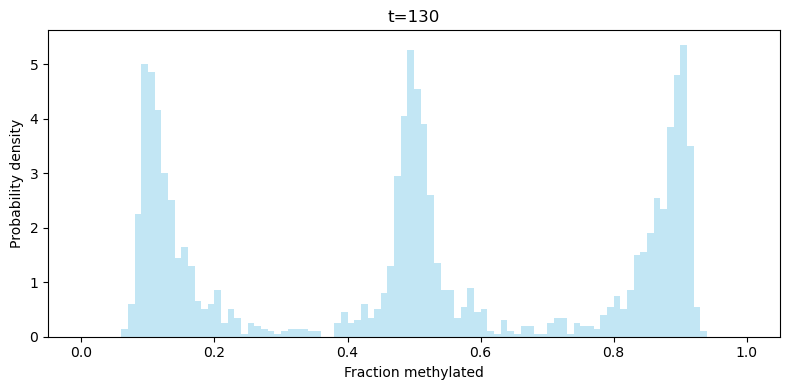

In [1844]:
fraction_methylated = population.mean(axis=0)
fig, ax = plt.subplots(figsize=(8,4))
plt.hist(fraction_methylated, np.linspace(0,1,101), density=True, alpha=0.5, linewidth=0, color='skyblue')
plt.xlabel("Fraction methylated")
plt.ylabel("Probability density")
plt.title(f"t={time_steps}")
plt.tight_layout()
plt.show()

In [ ]:
df = pd.DataFrame(population, columns=[f"CpG_{i}" for i in range(population.shape[1])])

In [ ]:
df.head(10)

In [ ]:
cells_count = population.shape[0]
print(f"Number of cells is {cells_count} at t={time_steps}")

In [1429]:
df.iloc[0:10, 0:15]

,CpG_0,CpG_1,CpG_2,CpG_3,CpG_4,CpG_5,CpG_6,CpG_7,CpG_8,CpG_9,CpG_10,CpG_11,CpG_12,CpG_13,CpG_14
0,1.0,0.5,1.0,1.0,0.0,1.0,1.0,0.5,1.0,0.5,1.0,0.5,0.0,0.5,1.0
1,1.0,0.5,1.0,1.0,0.0,1.0,1.0,0.5,1.0,0.5,1.0,0.5,0.0,0.5,1.0
2,1.0,0.5,1.0,1.0,0.0,1.0,1.0,0.5,1.0,0.5,1.0,0.5,0.0,0.5,1.0
3,1.0,0.5,1.0,1.0,0.0,1.0,0.5,0.5,1.0,0.5,1.0,0.5,0.0,0.5,1.0
4,1.0,0.5,1.0,1.0,0.0,1.0,1.0,0.5,1.0,0.5,1.0,0.5,0.0,0.5,1.0
5,1.0,0.5,1.0,1.0,0.0,1.0,0.5,0.5,1.0,0.5,1.0,0.5,0.0,0.5,1.0
6,1.0,0.5,1.0,1.0,0.0,1.0,1.0,0.5,1.0,0.5,1.0,0.5,0.0,0.5,1.0
7,1.0,0.5,1.0,1.0,0.0,1.0,1.0,0.5,1.0,0.5,1.0,0.5,0.0,0.5,1.0
8,1.0,0.5,1.0,1.0,0.0,1.0,1.0,0.5,1.0,0.5,1.0,0.5,0.0,0.5,1.0
9,1.0,0.5,1.0,1.0,0.0,1.0,1.0,0.5,1.0,0.5,1.0,0.5,0.0,0.5,1.0


In [1616]:
df.iloc[30:40, 0:15]

,CpG_0,CpG_1,CpG_2,CpG_3,CpG_4,CpG_5,CpG_6,CpG_7,CpG_8,CpG_9,CpG_10,CpG_11,CpG_12,CpG_13,CpG_14
30,0.0,0.5,1.0,0.0,1.0,0.0,0.5,0.5,1.0,1.0,0.5,1.0,0.5,0.0,1.0
31,0.0,0.5,1.0,1.0,1.0,0.0,0.5,0.5,1.0,1.0,0.5,1.0,0.5,0.0,1.0
32,0.0,0.5,1.0,0.0,1.0,0.0,0.5,0.5,1.0,1.0,0.5,1.0,0.5,0.0,0.5
33,0.0,0.5,0.5,0.5,1.0,0.0,0.5,0.5,1.0,1.0,0.0,1.0,0.5,0.0,1.0
34,0.0,0.5,1.0,0.0,1.0,0.0,0.5,0.5,0.5,1.0,0.5,1.0,0.5,0.0,1.0
35,0.0,1.0,1.0,0.5,0.5,0.0,0.5,0.5,1.0,1.0,0.5,1.0,0.5,0.0,0.5
36,0.0,0.5,1.0,0.5,1.0,0.0,0.5,0.5,1.0,1.0,0.5,1.0,0.5,0.0,1.0
37,0.0,0.5,1.0,0.5,0.5,0.0,0.5,0.5,0.0,1.0,0.5,1.0,0.5,0.0,1.0
38,0.0,0.5,1.0,0.0,1.0,0.0,0.5,0.5,0.5,1.0,0.5,1.0,0.5,0.0,1.0
39,0.0,0.5,1.0,0.5,1.0,0.0,0.5,0.5,1.0,1.0,0.5,1.0,0.5,0.0,1.0


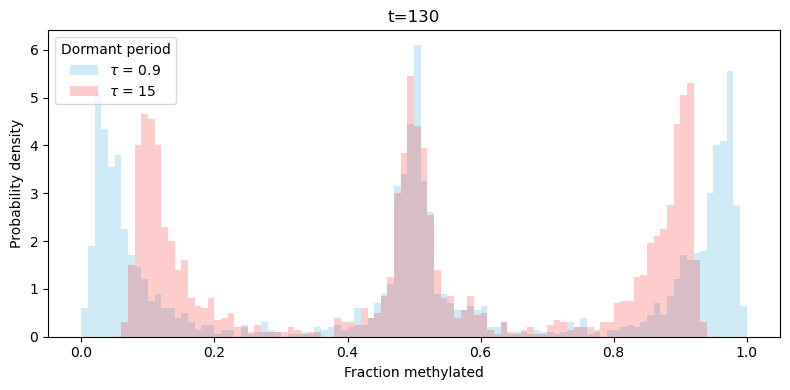

In [1804]:
fraction_tau1 = population_tau1.mean(axis=0)
fraction_tau2 = population_tau2.mean(axis=0)
bins = np.linspace(0, 1, 101)

fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(fraction_tau1,
        bins    = bins,
        density = True,
        alpha   = 0.4,
        color   = 'skyblue',
        label   = f'$\\tau$ = {tau_1}')
ax.hist(fraction_tau2,
        bins    = bins,
        density = True,
        alpha   = 0.2,
        color   = 'red',
        label   = f'$\\tau$ = {tau_2}')

ax.set_xlabel("Fraction methylated")
ax.set_ylabel("Probability density")
ax.set_title("t=130")
ax.legend(title="Dormant period")

plt.tight_layout()
plt.show()